In [1]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
data_path = r"C:\Users\data to cluster"  # Replace with the path to your CSV file
df = pd.read_csv(data_path)

In [4]:
# Remove outliers using the IQR method
def remove_outliers(df):
    numeric_df = df.select_dtypes(include=[float, int])  # Select only numeric columns
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1
    df_clean = df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_clean

# Apply the outlier removal function
df_clean = remove_outliers(df.iloc[:, 1:])  # Exclude the patient_label column

# Add the patient_label column back to the cleaned dataframe
df_clean = pd.concat([df[['patient_label']], df_clean], axis=1)



In [5]:
# Ensure only numeric columns are used for feature selection and clustering
numeric_columns = df_clean.select_dtypes(include=[float, int]).columns

# Handle NaN values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
df_clean[numeric_columns] = imputer.fit_transform(df_clean[numeric_columns])

# Feature selection using Variance Threshold
selector = VarianceThreshold(threshold=0.1)  # Adjust the threshold as needed
selected_features = selector.fit_transform(df_clean[numeric_columns])

In [6]:
# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

In [7]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the dataframe
df_clean['Cluster'] = clusters

# Save the clustered data to a new CSV file
clustered_data_path = 'fixed_clustered_data.csv'
df_clean.to_csv(clustered_data_path, index=False)

In [8]:
#Calculate the average angles for each patient label
summary_df = df_clean.groupby('patient_label').mean().reset_index()

# Rename columns to match the format of summary_angles.csv
summary_df.columns = [
    'patient_label', 'avg_hip_knee_angle', 'avg_knee_ankle_angle', 'avg_hip_knee_angle_r', 'avg_knee_ankle_angle_r',
    'avg_left_shoulder_elbow_angle', 'avg_left_elbow_wrist_angle', 'avg_right_shoulder_elbow_angle', 'avg_right_elbow_wrist_angle', 'avg_cluster'
]

# Save the summary angles to a new CSV file
summary_angles_path = 'summary_angles.csv'
summary_df.to_csv(summary_angles_path, index=False)

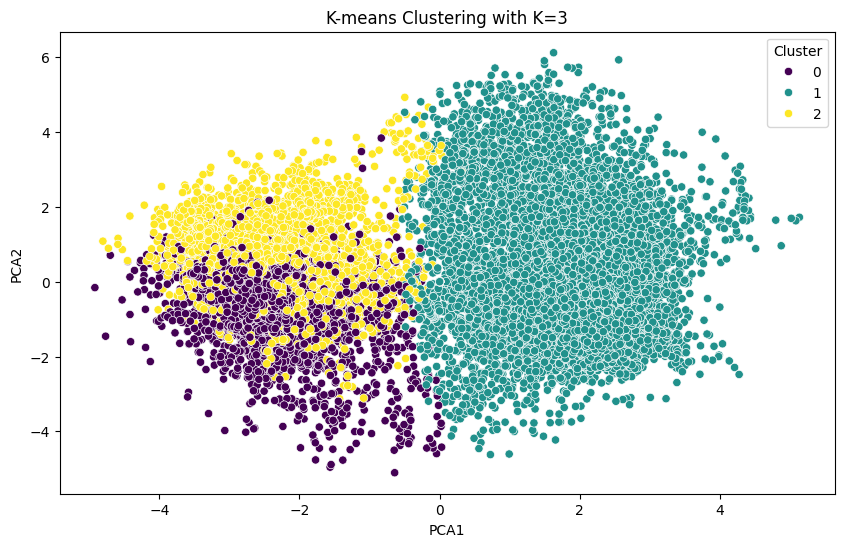

In [9]:
# Visualize the clusters
# For visualization, we need to reduce the dimensions to 2D using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Create a DataFrame with the PCA features and cluster labels
pca_df = pd.DataFrame(data=pca_features, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=pca_df)
plt.title('K-means Clustering with K=3')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()